Welcome to the SLURP Whisper notebook. This notebook was used in exploration of the best confidence threshold to use for the tool itself. First, it installs our version of Whisper and necesary libraries. It also installs the SLURP dataset. Then, it loads the SLURP data and the Whisper model, and finally, it graphs how many clarification questions are asked versus how many word errors we catch for each threshold value for us to chose the best threshold.

We used the following websites to aid in our research and help us build this notebook: https://huggingface.co/openai/whisper-base.en and https://github.com/pswietojanski/slurp.git

# **Install SLURP**

The following cell installs our version of whisper, helper libraries, and the SLURP dataset.

In [ ]:
%%capture
def installations():
  #Whisper installation
  !pip install git+https://github.com/evaprakash/whisper.git
  #Helper library for word error
  !pip install jiwer
  #Helper libraries
  !pip install torch torchvision torchaudio torchdata torchtext --index-url https://download.pytorch.org/whl/cu118
  #Download SLURP
  ! git clone https://github.com/pswietojanski/slurp.git
  !/content/slurp/scripts/download_audio.sh
installations()

# **Data Loader**

This cell does data preprocessing such that we interact with the dataset using our models.

In [ ]:
slurp_real_path = '/content/audio/slurp_real'
metadata_path = '/content/slurp/dataset/slurp/metadata.json'
import torch
import torchaudio
# import pandas as pd
import os
import json
import whisper


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class VoiceCommand(torch.utils.data.Dataset):
    def __init__(self, device=DEVICE):
      f = open(metadata_path)
      metadata = json.load(f)
      paths = []
      ground_truth = []
      for key in metadata.keys():
        ground_T = metadata[key]['sentence_original']
        # ground_T = metadata[key]['sentence_normalized']
        for key2 in metadata[key]['recordings'].keys():
          paths.append(key2)
          ground_truth.append(ground_T)
      self.dataset = [torchaudio.load(slurp_real_path + "/" + path) for path in paths[0:5000]]
      self.groundTruth = ground_truth
      self.device = DEVICE

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, item):
      audio, sample_rate = self.dataset[item]
      audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
      mel = whisper.log_mel_spectrogram(audio)
      text = self.groundTruth[item]
      return (mel, text)
dataset = VoiceCommand()
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

# **Running Inference Using Whisper**

This cell loads our model, processor, normalizer, and NLTK for future data processing purposes.

In [ ]:
%%capture

import whisper
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import jiwer
from whisper.normalizers import EnglishTextNormalizer


model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)
options = whisper.DecodingOptions(language="en", without_timestamps=True)


processor = WhisperProcessor.from_pretrained("openai/whisper-base.en")
normalizer = EnglishTextNormalizer()

import nltk
nltk.download("popular")




The following cells gathers all of the data into three arrays: 1) ts which is an array of arrays. Each inner array contains the confidence scores of the corresponding token 2) tokens is an array of arrays of tokens 3) hypotheses is an array of what whisper thought it heard 4) references is an array of reference texts

In [ ]:
%%capture
from tqdm.notebook import tqdm
ts = []
tokens = []
hypotheses = []
references = []
i = 0
for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    x = 0
    for result in results:
      ts.append(result.token_scores)
      tokens.append(result.tokens)
      hypotheses.append(result.text)
      references.append(texts[x])
      x += 1
    i += 1

This cell finds all of the words that are different between what whisper heard and the ground truth. It does this by looping through each example and employing a library called difflib to find out which tokens are incorrect. It employs the library because it is hard to understand where the discrepancies occur. For example, you cannot just do token to token analysis because 5 a.m. is semantically the same as 5am. This library contains a set of rules that advance the analysis begin done. Please note, we only took into account words longer or equal to three because these longer words are the most important in gauging understanding.

In [ ]:
import difflib
import string
WORD_LEN = 3

diffWords = []
transcriptions = []
def findDiffWords(ref, hyp):
  ref = ref.lower()
  hyp = hyp.lower()
  ref = ref.translate(str.maketrans('', '', string.punctuation))
  hyp = hyp.translate(str.maketrans('', '', string.punctuation))
  ref = [r + "\n" for r in ref.split()]
  hyp = [h + "\n" for h in hyp.split()]
  diff = difflib.ndiff(ref, hyp)
  diff = ''.join(diff)
  diff = diff.split("\n")
  diff_words = []
  for d in diff:
    if len(d) > 0:
      if d[0] == "+":
        word = d.split()[1]
        if (len(word) >= WORD_LEN):
          diff_words.append(word)
  diff_words = list(set(diff_words))
  return diff_words

total = 5000

for i in range(total):
    ref = references[i]
    hyp = hypotheses[i]
    transcription_raw = processor.batch_decode(tokens[i], skip_special_tokens=False)
    transcription = []
    for t in transcription_raw:
      transcription.append(t.strip())
    transcription = [x.lower() for x in transcription]
    transcriptions.append(transcription)
    currDiffWords = findDiffWords(ref, hyp)
    diffWords.append(currDiffWords)

This cell does the analysis of creating results for the different confidence thresholds. It does this by looping through all the different confidence thresholds and calling the method collect_error_words on each example. This method does two things 1) goes through each consquent words triplet in the hypothesis and sees if the aggregate (mean) confidence score is less than the confidence threshold. It if it is then we mark that we will ask a clarification question on this hypothesis and we also mark which words caused the clarification question. 2) This method then checks to see if we ask clarification questions on the words that were wrong, as calculated in the above cell. We collate these responses and find overall % of examples we ask clarification questions for and overall % of word errors we find for each threshold value. We used 21 threshold values of 0.0 till 1.0 with intervals of 0.05.

In [ ]:
def collect_error_words(index, threshold):
  transcription = transcriptions[index]
  token_scores = ts[index]
  total_error_words = 0
  t_err_w_found = 0

  wordsClarified= {}
  clarifications = []
  clarify = 0
  for word in transcription:
    wordsClarified[word] = 0

  for i in range(len(token_scores)-2):
    word1 = transcription[i]
    word2 = transcription[i+1]
    word3 = transcription[i+2]
    score = (token_scores[i] + token_scores[i+1] + token_scores[i+2])/3
    if score <= threshold:
      clarifications.append(1)
      wordsClarified[word1] = 1
      wordsClarified[word2] = 1
      wordsClarified[word3] = 1
      clarify = 1
    else:
      clarifications.append(0)
  # print(wordsClarified)

  for w in diffWords[index]:
    if w in transcription and w in nltk.corpus.words.words():
      total_error_words += 1
      curr_token_idx = transcription.index(w)
      curr_ts = token_scores[curr_token_idx]
      if wordsClarified[w] == 1:
        t_err_w_found += 1


  return clarify, t_err_w_found, total_error_words

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
results = []
for threshold in thresholds:
  num_clarify = 0
  num_discovered = 0
  num_errors = 0
  for i in range(total):
    currClarify, currDiscovered, currErrors = collect_error_words(i, threshold)
    num_clarify += currClarify
    num_discovered += currDiscovered
    num_errors += currErrors
  result = (float(num_clarify)/float(total), num_discovered, float(num_discovered)/float(num_errors))
  print("Result: ", str(result))
  results.append(result)
  print("Done ", str(threshold))

Result:  (0.0, 0, 0.0)
Done  0
Result:  (0.0, 0, 0.0)
Done  0.05
Result:  (0.0036, 7, 0.0015411712901805372)
Done  0.1
Result:  (0.0144, 64, 0.014090708938793483)
Done  0.15
Result:  (0.0318, 155, 0.03412593571114047)
Done  0.2
Result:  (0.0602, 329, 0.07243505063848525)
Done  0.25
Result:  (0.0926, 572, 0.12593571114046676)
Done  0.3
Result:  (0.1312, 850, 0.18714222809335096)
Done  0.35
Result:  (0.1688, 1160, 0.25539409951563186)
Done  0.4
Result:  (0.2216, 1572, 0.34610303830911493)
Done  0.45
Result:  (0.2704, 1924, 0.4236019374724791)
Done  0.5
Result:  (0.3332, 2323, 0.5114487010127697)
Done  0.55
Result:  (0.4014, 2729, 0.6008366358432409)
Done  0.6
Result:  (0.4758, 3124, 0.6878027300748569)
Done  0.65
Result:  (0.5578, 3480, 0.7661822985468957)
Done  0.7
Result:  (0.6444, 3749, 0.825407309555262)
Done  0.75
Result:  (0.7354, 3982, 0.876706296785557)
Done  0.8
Result:  (0.8378, 4206, 0.9260237780713342)
Done  0.85
Result:  (0.9124, 4336, 0.9546455306032585)
Done  0.9
Result:  

In [ ]:
results= [(0.0, 0, 0.0), (0.0, 0, 0.0), (0.0036, 7, 0.0015411712901805372), (0.0144, 64, 0.014090708938793483), (0.0318, 155, 0.03412593571114047), (0.0602, 329, 0.07243505063848525), (0.0926, 572, 0.12593571114046676), (0.1312, 850, 0.18714222809335096), (0.1688, 1160, 0.25539409951563186), (0.2216, 1572, 0.34610303830911493), (0.2704, 1924, 0.4236019374724791), (0.3332, 2323, 0.5114487010127697), (0.4014, 2729, 0.6008366358432409), (0.4758, 3124, 0.6878027300748569), (0.5578, 3480, 0.7661822985468957), (0.6444, 3749, 0.825407309555262), (0.7354, 3982, 0.876706296785557), (0.8378, 4206, 0.9260237780713342), (0.9124, 4336, 0.9546455306032585), (0.9634, 4454, 0.980625275209159), (1, 4520, 1)]

In [ ]:
points = [str(round(i*0.05,2)) for i in range(21)]

This cell plots the results found from the previous analysis. It labels each other points with the confidence threshold it corresponds to.

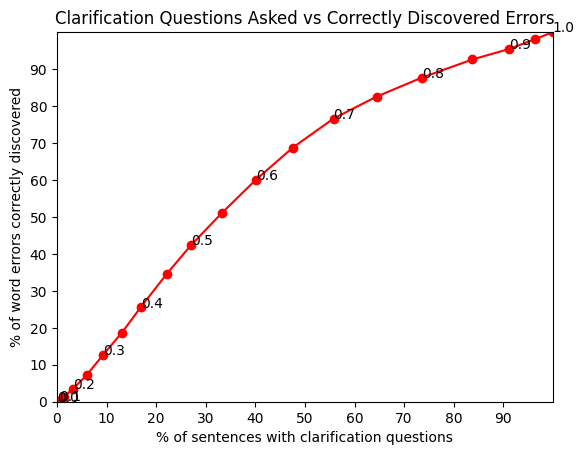

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [i[0] * 100 for i in results]
y = [i[2] * 100  for i in results]

plt.scatter(x,y, color='red')
for i in range(len(points)):
  if i % 2 == 0:
    plt.annotate(points[i], (x[i], y[i]))
plt.plot(x,y, color='red')
plt.title("Clarification Questions Asked vs Correctly Discovered Errors")
plt.xlabel("% of sentences with clarification questions")
plt.ylabel("% of word errors correctly discovered")
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.xticks(np.arange(0, 100, 10))
plt.yticks(np.arange(0, 100, 10))
plt.show()

# **Calculate Word Error Rate**

This prints the overall word error of our tool! Sometimes the english text normalizer messes up, so we remove all the "mess ups"

In [ ]:
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

hypothesis_clean = [normalizer(text) for text in hypotheses]
reference_clean = [normalizer(text) for text in references]

references1 = []
hypotheses1 = []

length = len(reference_clean) if len(hypothesis_clean) > len(reference_clean) else len(hypotheses)

for i in range(length):
  if hypothesis_clean[i] != "" and reference_clean[i] != "":
    references1.append(reference_clean[i])
    hypotheses1.append(hypothesis_clean[i])

wer = jiwer.wer(list(references1), list(hypotheses1))
print("WER for using the sentence normalized for the ground truth")
print(f"WER: {wer * 100:.2f} %")

print()

wer = jiwer.wer(list(references1), list(hypotheses1))
print("WER for using the sentence original for the ground truth")
print(f"WER: {wer * 100:.2f} %")


WER for using the sentence normalized for the ground truth
WER: 29.46 %

WER for using the sentence original for the ground truth
WER: 29.46 %
